## Synchronizing the Tile Data with Garmin F6P Ground Truth

This is more of a testing step since the garmin data only represents the runs and will contain tracking gaps for the lifts. Regardless, it'll be good to test the synchronization compared to the garmin ground truth using the a50-synched tile data. 

In comparison to the a50 track recognition, I believe garmin uses the lift points to register runs instead of reacting to current states. This makes sense as it's more of an activity tracker and less of a gpx generator/mapper.

In [1]:
from decode import decode_A50, decode_A50_downhill, decode_F6P, decode_tile
import matplotlib.pyplot as plt
from sync import syncTile, splitTileIntoDownhillTracks
from tile import Tile
from track import Track

a50 = decode_A50_downhill("../DATA/2023_12_31/Mt St Sauveur/A50/Mount St Sauveur PATCHED.csv")
a50_all = decode_A50("../DATA/2023_12_31/Mt St Sauveur/A50/Mount St Sauveur PATCHED.csv")
f6p = decode_F6P("../DATA/2023_12_31/Mt St Sauveur/F6P/13306856415_ACTIVITY.csv")
tile = decode_tile("../DATA/2023_12_31/Mt St Sauveur/Tile/SENS000.CSV")

In [2]:
stitched_f6p_time = []
stitched_f6p_alt = []

for track in f6p: 
    stitched_f6p_time += track.time
    stitched_f6p_alt += track.alt

print(len(stitched_f6p_time), 'f6p samples')
print(len(tile.raw_alt()), 'tile samples')

2878 f6p samples
1446198 tile samples


In [3]:
tile_sync = syncTile(
    tile=tile,
    truth=a50_all,
    alt_step=0.25,
    min_alt_start=42,
    max_alt_search=46)

3%
6%
10%
13%
16%
19%
23%
26%
29%
32%
35%
39%
42%
45%
48%
52%
55%
58%
61%
65%
68%
71%
74%
77%
81%
84%
87%
90%
94%
97%
Timestamp offset: 100
Altitude offset: 42.5


## Plotting

The straight lines represent the skips/gaps in the garmin tracking data & approximate the combined hold & lift tracks.

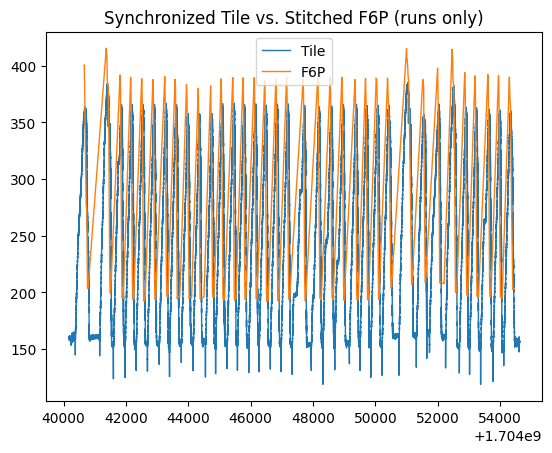

In [4]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(tile_sync.time, tile_sync.alt, label='Tile')
ax.plot(stitched_f6p_time, stitched_f6p_alt, label='F6P')
ax.set_title('Synchronized Tile vs. Stitched F6P (runs only)', wrap=True)
ax.legend()
plt.show()

Looks like the elevation captured by the f6p was consistently higher than both the a50 (which synchronized the offset for the tile data here). I trust the garmin data more here since it's measured barometrically on the wrist and is corrected for the weather offsets (allegedly). Therefore, if it's a requirement to process the pressure data to end up with a true altitude signal I'll use this ground truth.

However, since the goal was only to synchronize the signal and assign global timestamps, the runs look to be matching on the time axis which is all we need here. We can however, use the garmin timestamps to split up the tile data into tile-specific tracks.

### Aside: Synchronize with F6P

This is exploratory since there's gaps in the f6p data and requires some hardcoding to offset on the time axis. Regardless, it shows good results if a pressure dataset is required for non-alignment analysis.

In [ ]:
tile_sync_f6p = syncTile(
    tile=tile,
    truth=f6p,
    use_mae=False,
    time_step_s=0.5,
    max_time_search_s=100,
    alt_step=0.5,
    min_alt_start=0,
    max_alt_search=10)

1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
Timestamp offset: 34000
Altitude offset: 7.5


In [ ]:
shifted_tile_sync_f6p_time = [t - 200 for t in tile_sync_f6p.time]

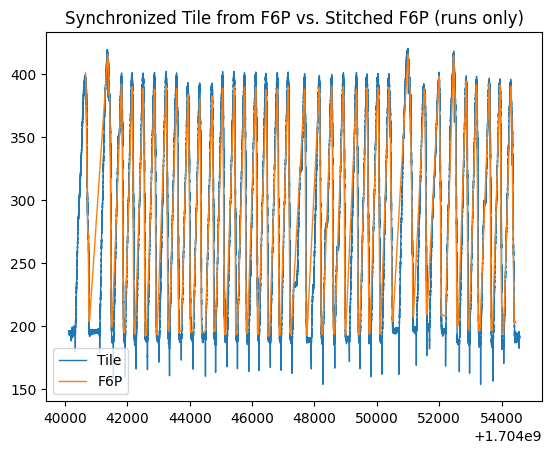

In [ ]:
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots()
ax.plot(shifted_tile_sync_f6p_time, tile_sync_f6p.alt, label='Tile')
# ax.plot(tile_sync_f6p.time, tile_sync_f6p.alt, label='Tile')
ax.plot(stitched_f6p_time, stitched_f6p_alt, label='F6P')
ax.set_title('Synchronized Tile from F6P vs. Stitched F6P (runs only)', wrap=True)
ax.legend()
plt.show()